In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from statsmodels.tsa.arima.model import ARIMA
from nbeats_pytorch.model import NBeatsNet

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
chunksize = 10000

reader = pd.read_csv(
    "/data/hmn_data/alibaba_cluster_data/MSRT_Qps_Resource.csv", chunksize=chunksize)


In [3]:
df = pd.DataFrame()
for index, chunk in enumerate(reader):
        if index > 1:
            break
        df = pd.concat([df, chunk])

In [4]:
print(df.shape)
df.head(720)

(20000, 5)


,msinstanceid,timestamp,HTTP_RT,instance_cpu_usage,instance_memory_usage
0,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,0,7.19509,0.448875,0.685655
1,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,60000,7.11811,0.482167,0.686265
2,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,120000,6.98522,0.475833,0.686841
3,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,180000,7.65488,0.503583,0.687666
4,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,240000,7.21725,0.503250,0.688608
...,...,...,...,...,...
715,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,42900000,6.30103,0.488292,0.690547
716,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,42960000,6.45199,0.467333,0.688980
717,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,43020000,6.49800,0.465708,0.689341
718,00008c44230137c49ee03f7b952b724134e0ba4197d55b...,43080000,6.54989,0.505083,0.689348


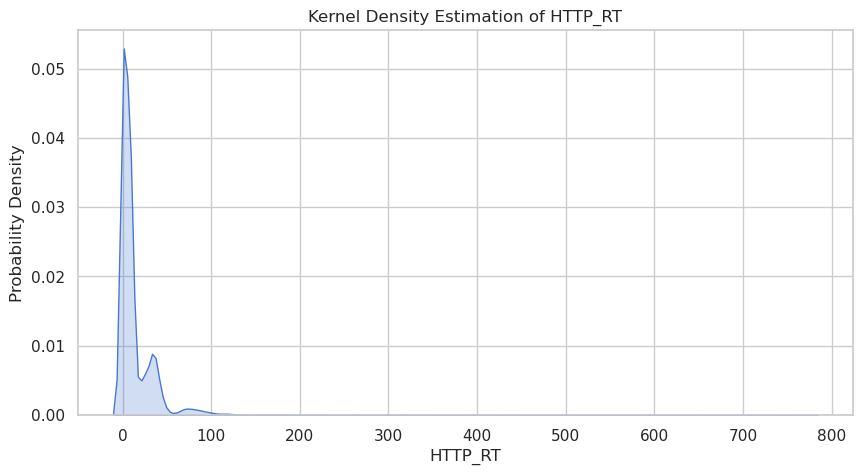

In [5]:
# 绘制数据分布图
plt.figure(figsize=(10, 5))
sns.set(style='whitegrid', palette='muted')
sns.kdeplot(data=df, x='HTTP_RT',  fill=True)
plt.xlabel('HTTP_RT')
plt.ylabel('Probability Density')
plt.title('Kernel Density Estimation of HTTP_RT')
plt.show()



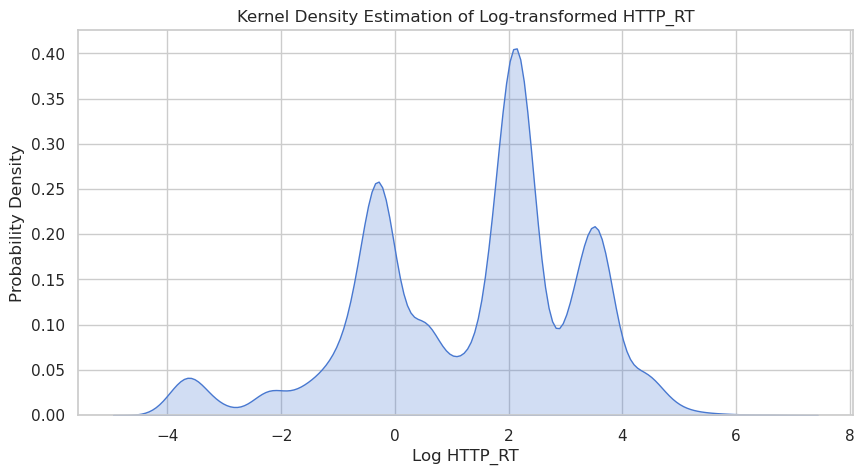

In [6]:
# 对 HTTP_MCR 应用对数变换
df['LOG_HTTP_RT'] = np.log(df['HTTP_RT'])
# 绘制对数变换后的核密度估计图
plt.figure(figsize=(10, 5))
sns.set(style='whitegrid', palette='muted')
sns.kdeplot(data=df, x='LOG_HTTP_RT', fill=True)
plt.xlabel('Log HTTP_RT')
plt.ylabel('Probability Density')
plt.title('Kernel Density Estimation of Log-transformed HTTP_RT')
plt.show()

In [7]:
def split_array_by_step(df, K):
    q_5 = df['HTTP_RT'].quantile(0.05)
    q_95 = df['HTTP_RT'].quantile(0.95)
    df = df[(df['HTTP_RT'] >= q_5) & (df['HTTP_RT'] <= q_95)].dropna()

    df['Max_HTTP_RT'] = df['HTTP_RT'].rolling(window=K).max()
    df['Min_HTTP_RT'] = df['HTTP_RT'].rolling(window=K).min()
    df['Mean_HTTP_RT'] = df['HTTP_RT'].rolling(window=K).mean()
    df = df[["HTTP_RT",	"Max_HTTP_RT",	"Min_HTTP_RT",	"Mean_HTTP_RT",
             "instance_cpu_usage", "instance_memory_usage"]]
    df = df.iloc[K:]

    if len(df) == 0:
        return []

    scaler = MinMaxScaler()
    df[["HTTP_RT", "Max_HTTP_RT", "Min_HTTP_RT", "Mean_HTTP_RT", "instance_cpu_usage", "instance_memory_usage"]] = scaler.fit_transform(
        df[["HTTP_RT", "Max_HTTP_RT", "Min_HTTP_RT", "Mean_HTTP_RT", "instance_cpu_usage", "instance_memory_usage"]])

    # 遍历 DataFrame 的每一行，跳过前 K 行
    result = []
    for i in range(0, len(df) - K, 1):
        window = df.iloc[i:i+K]
        result.append(window)

    return result


In [8]:
# 定义步长 K
TIME_STEP = 5

# 按照 msinstanceid 列分组
grouped_df = df.groupby('msinstanceid')

http_rt_df = grouped_df.apply(
    lambda x: split_array_by_step(x, TIME_STEP+1))


In [9]:
http_rt_df[0][2]

,HTTP_RT,Max_HTTP_RT,Min_HTTP_RT,Mean_HTTP_RT,instance_cpu_usage,instance_memory_usage
8,0.446897,0.379099,0.329376,0.395916,0.206625,0.349852
9,0.774566,0.706185,0.329376,0.454062,0.445319,0.377311
10,0.726733,0.706185,0.329376,0.545453,0.386959,0.377311
11,0.610084,0.706185,0.329376,0.574821,0.370662,0.369106
12,0.637548,0.706185,0.329376,0.598719,0.535489,0.359151
13,0.413176,0.706185,0.487991,0.626886,0.320978,0.361011


In [10]:
workload = np.concatenate(http_rt_df, axis=0)
workload.shape

(17690, 6, 6)

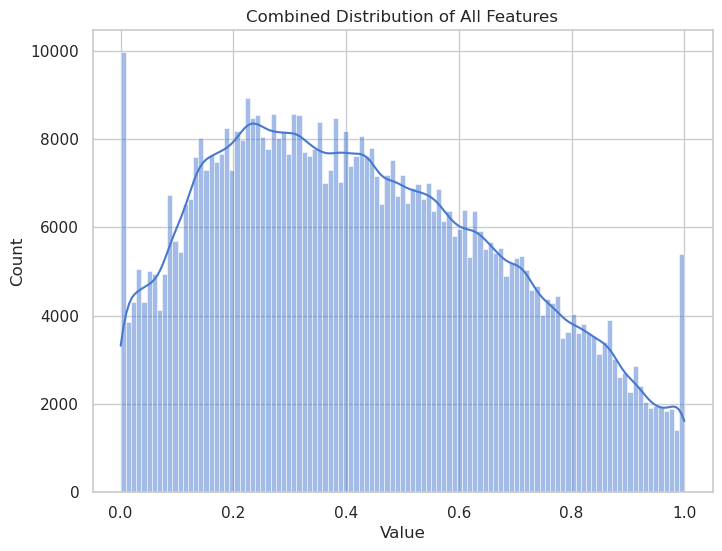

In [11]:
# 将所有值整形为一维数组
data_flat = workload.flatten()

# 绘制数据分布图
sns.set(style='whitegrid', palette='muted')
plt.figure(figsize=(8, 6))
sns.histplot(data_flat, kde=True)
plt.title("Combined Distribution of All Features")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()

In [12]:
# 将数据转换为LSTM模型的输入形式
def create_sequences(data, time_steps=1):
    xs, ys = [], []
    for i in range(len(data)):
        xs.append(data[i][:time_steps])
        ys.append(data[i][time_steps])
    return np.array(xs), np.array(ys)

x_train, y_train = create_sequences(workload, TIME_STEP)

In [13]:
print(x_train.shape)
print(y_train.shape)

(17690, 5, 6)
(17690, 6)


In [14]:
train_size = int(len(x_train) * 0.6)
val_size = int(len(x_train) * 0.2)
test_size = len(x_train) - train_size-val_size

x_train, x_val, x_test = x_train[:train_size, :, :], x_train[train_size:train_size +
                                                             val_size, :, :], x_train[train_size+val_size:, :, :]
y_train, y_val, y_test = y_train[:train_size], y_train[train_size:train_size +
                                                       val_size], y_train[train_size+val_size:]


In [15]:
# 定义步长 K
TIME_STEP = 5
INPUT_DIM = 6
output_dim = 6
batch_size = 10  # 每轮训练模型时，样本的数量
epochs = 50  # 训练60轮次
hidden_size = 64
layer_num = 4
patience = 10


In [16]:
class ARIMAModle:
    @staticmethod
    def train(train_data, p=2, d=1, q=2):
        # 设置ARIMA模型参数
        # AR阶数
        # 差分阶数
        # MA阶数

        predict = []

        for item in train_data:
            model = ARIMA(item, order=(p, d, q))
            model_fit = model.fit()
            res = model_fit.forecast(steps=1)
            predict.append(res)

        return np.array(predict)

In [17]:
class NBeatsModel:
    @staticmethod
    def model(input_dim=10, output_dim=1, hidden_size=32):
        model = NBeatsNet(stack_types=('generic', 'generic'),
                          nb_blocks_per_stack=3,
                          thetas_dim=(4, 4),
                          forecast_length=output_dim,
                          backcast_length=input_dim,
                          hidden_layer_units=hidden_size,
                          share_weights_in_stack=True)
        return model

    @staticmethod
    def validate(model, criterion, dataloader):
        running_loss = 0.0
        total_samples = 0

        for batch_x, batch_y in dataloader:
            _, output = model(batch_x)
            loss = criterion(output, batch_y)

            running_loss += loss.item() * batch_x.size(0)
            total_samples += batch_x.size(0)

        epoch_loss = running_loss / total_samples
        return epoch_loss

    @staticmethod
    def train_model(train_x, train_y, val_x, val_y, model, epochs, batch_size, device, patience=3):
        train_x = torch.tensor(train_x, dtype=torch.float32).to(device)
        train_y = torch.tensor(train_y, dtype=torch.float32).to(device)
        dataset = TensorDataset(train_x, train_y)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        val_x = torch.tensor(val_x, dtype=torch.float32).to(device)
        val_y = torch.tensor(val_y, dtype=torch.float32).to(device)
        val_dataset = TensorDataset(val_x, val_y)
        val_dataloader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=True)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters())

        # scheduler = ReduceLROnPlateau(optimizer, patience=1, verbose=True)

        for epoch in range(epochs):
            running_loss = 0.0
            total_samples = 0

            for batch_x, batch_y in dataloader:
                optimizer.zero_grad()
                _, output = model(batch_x)
                loss = criterion(output, batch_y)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * batch_x.size(0)
                total_samples += batch_x.size(0)

            epoch_loss = running_loss / total_samples
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.6f}")

            # 在每个epoch后进行验证并检查早停
            # with torch.no_grad():
            #     val_loss = NBeatsModel.validate(
            #         model, criterion, val_dataloader)
            #     print(f"Validation Loss: {val_loss:.6f}")

            #     # 更新学习率
            #     scheduler.step(val_loss)

        return model

    @staticmethod
    def predict(model, predict_x, device):
        predict_x = torch.tensor(predict_x, dtype=torch.float32).to(device)
        model.eval()
        with torch.no_grad():
            _, y_pred = model(predict_x)
        return y_pred.cpu().numpy()


In [18]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1, dropout=0.1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=False, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out


In [19]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1, dropout=0.1):
        super(BiLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0),
                         self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0),
                         self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out


In [20]:
class Attention(nn.Module):
    def __init__(self, lstm_hidden_size):
        super(Attention, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.attention_vec = nn.Linear(
            lstm_hidden_size * 2, lstm_hidden_size * 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, lstm_out):
        attention_probs = self.sigmoid(self.attention_vec(lstm_out))
        return attention_probs * lstm_out


class LSTM_fun_PyTorch_att(nn.Module):
    def __init__(self, input_dim, seq_len, output_dim, lstm_hidden_size=128, dropout=0.1):
        super(LSTM_fun_PyTorch_att, self).__init__()
        self.conv1d = nn.Conv1d(input_dim, 32, kernel_size=1)
        self.relu = nn.ReLU()
        self.maxpool1d = nn.MaxPool1d(seq_len)
        self.dropout = nn.Dropout(0.1)
        self.bilstm = nn.LSTM(32, lstm_hidden_size,
                              bidirectional=True, dropout=dropout)
        self.attention = Attention(lstm_hidden_size)
        self.fc = nn.Linear(lstm_hidden_size * 2, output_dim)

    def forward(self, inputs):
        x = self.conv1d(inputs)
        x = self.relu(x)
        x = self.maxpool1d(x)
        x = self.dropout(x)
        x = x.transpose(1, 2)
        lstm_out, _ = self.bilstm(x)
        attention_mul = self.attention(lstm_out)
        output = self.fc(attention_mul)
        return output.squeeze()


In [21]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, delta=0, verbose=False, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            path (str): Path to save checkpoint.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.path = path
        self.trace_func = trace_func
        self.best_loss = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(val_loss, model)
            if self.verbose:
                self.trace_func(f"Validation loss decreased {self.delta:.6f} units or more, saving model.")

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f"Validation loss decreased. Saving model ...")
        torch.save(model.state_dict(), self.path)
        self.best_loss = val_loss

In [22]:
def validate(model, criterion, dataloader):
    running_loss = 0.0
    total_samples = 0

    for batch_x, batch_y in dataloader:
        output = model(batch_x)
        loss = criterion(output, batch_y)

        running_loss += loss.item() * batch_x.size(0)
        total_samples += batch_x.size(0)

    epoch_loss = running_loss / total_samples

    return epoch_loss

In [23]:
def train_model(train_x, train_y, val_x, val_y, model, epochs, batch_size, device, patience=3):
    loss_array, val_loss_array = [], []

    train_x = torch.tensor(train_x, dtype=torch.float32).to(device)
    train_y = torch.tensor(train_y, dtype=torch.float32).to(device)
    dataset = TensorDataset(train_x, train_y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    val_x = torch.tensor(val_x, dtype=torch.float32).to(device)
    val_y = torch.tensor(val_y, dtype=torch.float32).to(device)
    val_dataset = TensorDataset(val_x, val_y)
    val_dataloader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    scheduler = ReduceLROnPlateau(optimizer, patience=patience, verbose=True)
    # early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(epochs):
        running_loss = 0.0
        total_samples = 0

        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_x.size(0)
            total_samples += batch_x.size(0)

        epoch_loss = running_loss / total_samples
        loss_array.append(epoch_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.6f}")

        # 在每个epoch后进行验证并检查早停
        with torch.no_grad():
            val_loss = validate(model, criterion, val_dataloader)
            val_loss_array.append(val_loss)
            print(f"Validation Loss: {val_loss:.6f}")

            # 更新学习率
            scheduler.step(val_loss)

            # 检查早停
            # early_stopping(val_loss, model)
            # if early_stopping.early_stop:
            #     print("Early stopping")
            #     break

    return model, loss_array, val_loss_array


In [24]:
def predict(model, predict_x, device):
    predict_x = torch.tensor(predict_x, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        y_pred = model(predict_x)
    return y_pred.cpu().numpy()

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lstm_model = LSTMModel(INPUT_DIM, hidden_size,
                       layer_num, output_dim).to(device)

lstm_model_trained, loss_array, val_loss_array = train_model(x_train, y_train, x_val, y_val, lstm_model,
                                                             epochs, batch_size, device, patience=patience)


Epoch 1/50, Loss: 0.047155
Validation Loss: 0.050391
Epoch 2/50, Loss: 0.034095
Validation Loss: 0.048937
Epoch 3/50, Loss: 0.033534
Validation Loss: 0.046193
Epoch 4/50, Loss: 0.031434
Validation Loss: 0.043539
Epoch 5/50, Loss: 0.027072
Validation Loss: 0.032020
Epoch 6/50, Loss: 0.024653
Validation Loss: 0.028258
Epoch 7/50, Loss: 0.022573
Validation Loss: 0.025711
Epoch 8/50, Loss: 0.019511
Validation Loss: 0.023078
Epoch 9/50, Loss: 0.017545
Validation Loss: 0.021658
Epoch 10/50, Loss: 0.016873
Validation Loss: 0.021018
Epoch 11/50, Loss: 0.016597
Validation Loss: 0.020337
Epoch 12/50, Loss: 0.016278
Validation Loss: 0.019907
Epoch 13/50, Loss: 0.016000
Validation Loss: 0.020034
Epoch 14/50, Loss: 0.015848
Validation Loss: 0.019590
Epoch 15/50, Loss: 0.015465
Validation Loss: 0.019452
Epoch 16/50, Loss: 0.015322
Validation Loss: 0.019270
Epoch 17/50, Loss: 0.015166
Validation Loss: 0.018697
Epoch 18/50, Loss: 0.014951
Validation Loss: 0.018753
Epoch 19/50, Loss: 0.014901
Validatio

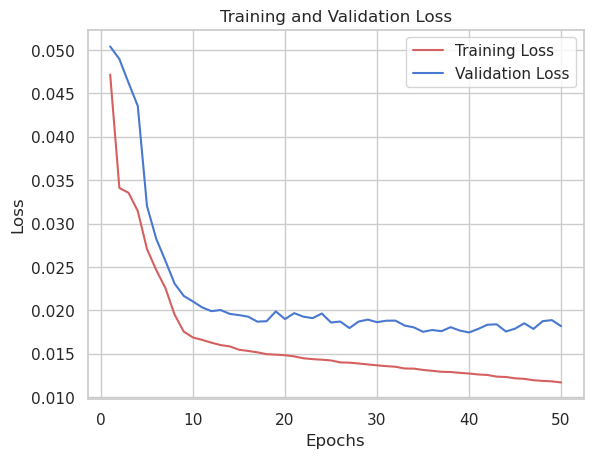

In [26]:
es = range(1, len(loss_array) + 1)

plt.plot(es, loss_array, 'r', label='Training Loss')
plt.plot(es, val_loss_array, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

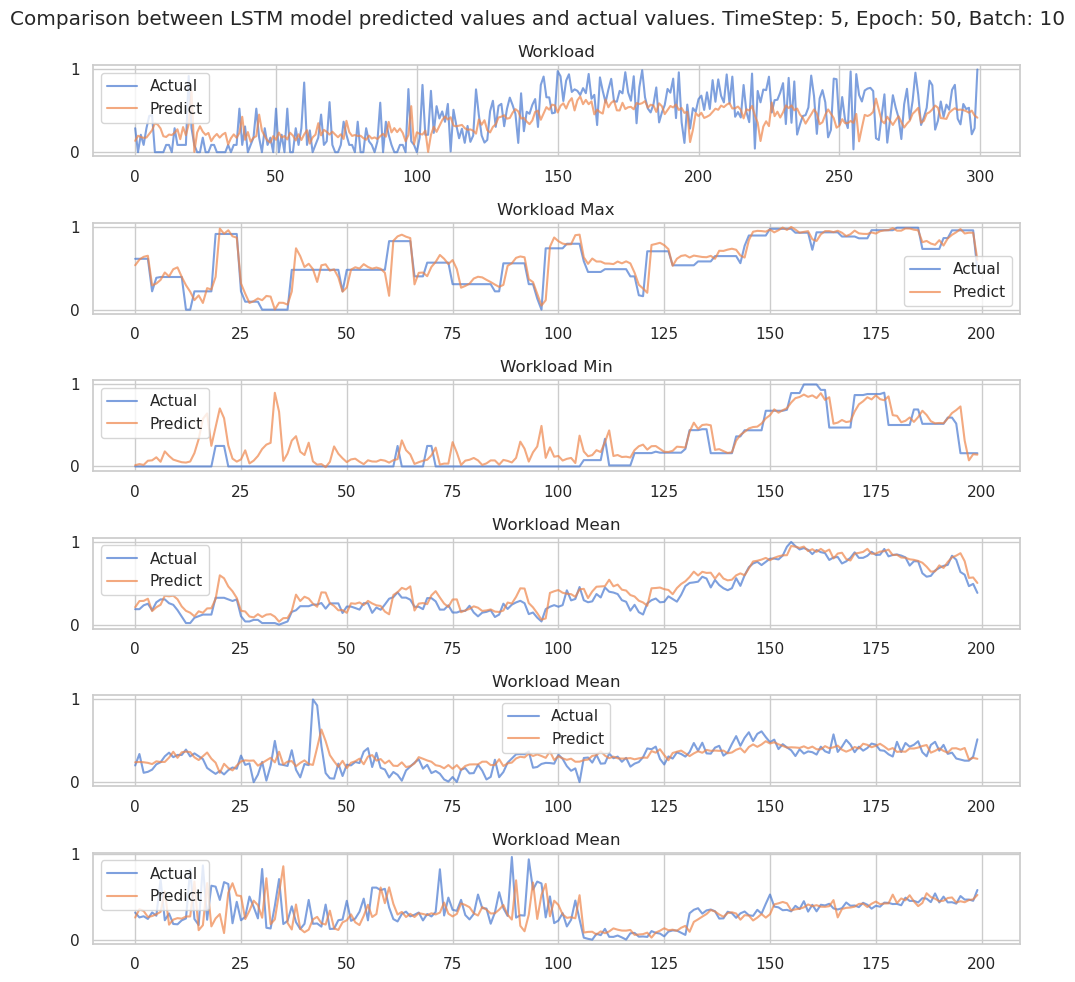

In [32]:
lstm_pred = predict(lstm_model_trained, x_test, device)
y_pred = lstm_pred

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 10))
axes = axes.flatten()


ax = axes[0]
ax.plot(y_test[:300, 0], label='Actual', alpha=0.7)
ax.plot(y_pred[:300, 0], label='Predict', alpha=0.7)
ax.set_title(f'Workload')
ax.legend()


ax = axes[1]
ax.plot(y_test[:200, 1], label='Actual', alpha=0.7)
ax.plot(y_pred[:200, 1], label='Predict', alpha=0.7)
ax.set_title(f'Workload Max')
ax.legend()

ax = axes[2]
ax.plot(y_test[:200, 2], label='Actual', alpha=0.7)
ax.plot(y_pred[:200, 2], label='Predict', alpha=0.7)
ax.set_title(f'Workload Min')
ax.legend()

ax = axes[3]
ax.plot(y_test[:200, 3], label='Actual', alpha=0.7)
ax.plot(y_pred[:200, 3], label='Predict', alpha=0.7)
ax.set_title(f'Workload Mean')
ax.legend()

ax = axes[4]
ax.plot(y_test[:200, 4], label='Actual', alpha=0.7)
ax.plot(y_pred[:200, 4], label='Predict', alpha=0.7)
ax.set_title(f'Workload Mean')
ax.legend()


ax = axes[5]
ax.plot(y_test[:200, 5], label='Actual', alpha=0.7)
ax.plot(y_pred[:200, 5], label='Predict', alpha=0.7)
ax.set_title(f'Workload Mean')
ax.legend()

fig.suptitle('Comparison between LSTM model predicted values and actual values. TimeStep: {timestep}, Epoch: {epoch}, Batch: {batch}'.format(
    timestep=TIME_STEP, epoch=epochs, batch=batch_size))
plt.tight_layout()
plt.show()


In [28]:
bi_lstm_model  = BiLSTMModel(
    INPUT_DIM, hidden_size, layer_num, output_dim).to(device)

bi_lstm_model_trained, loss_array, val_loss_array = train_model(x_train, y_train, x_val, y_val, bi_lstm_model,
                                    epochs, batch_size, device, patience=patience)


Epoch 1/50, Loss: 0.041833
Validation Loss: 0.052124
Epoch 2/50, Loss: 0.033499
Validation Loss: 0.048645
Epoch 3/50, Loss: 0.030555
Validation Loss: 0.040879
Epoch 4/50, Loss: 0.024323
Validation Loss: 0.026340
Epoch 5/50, Loss: 0.020418
Validation Loss: 0.024963
Epoch 6/50, Loss: 0.018184
Validation Loss: 0.022402
Epoch 7/50, Loss: 0.017304
Validation Loss: 0.021776


KeyboardInterrupt: 

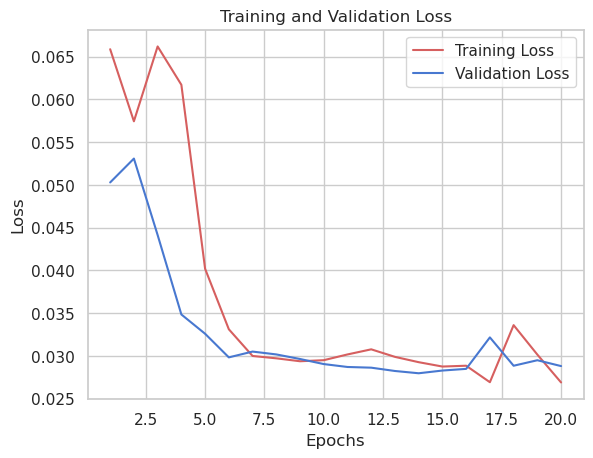

In [ ]:
es = range(1, len(loss_array) + 1)

plt.plot(es, loss_array, 'r', label='Training Loss')
plt.plot(es, val_loss_array, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

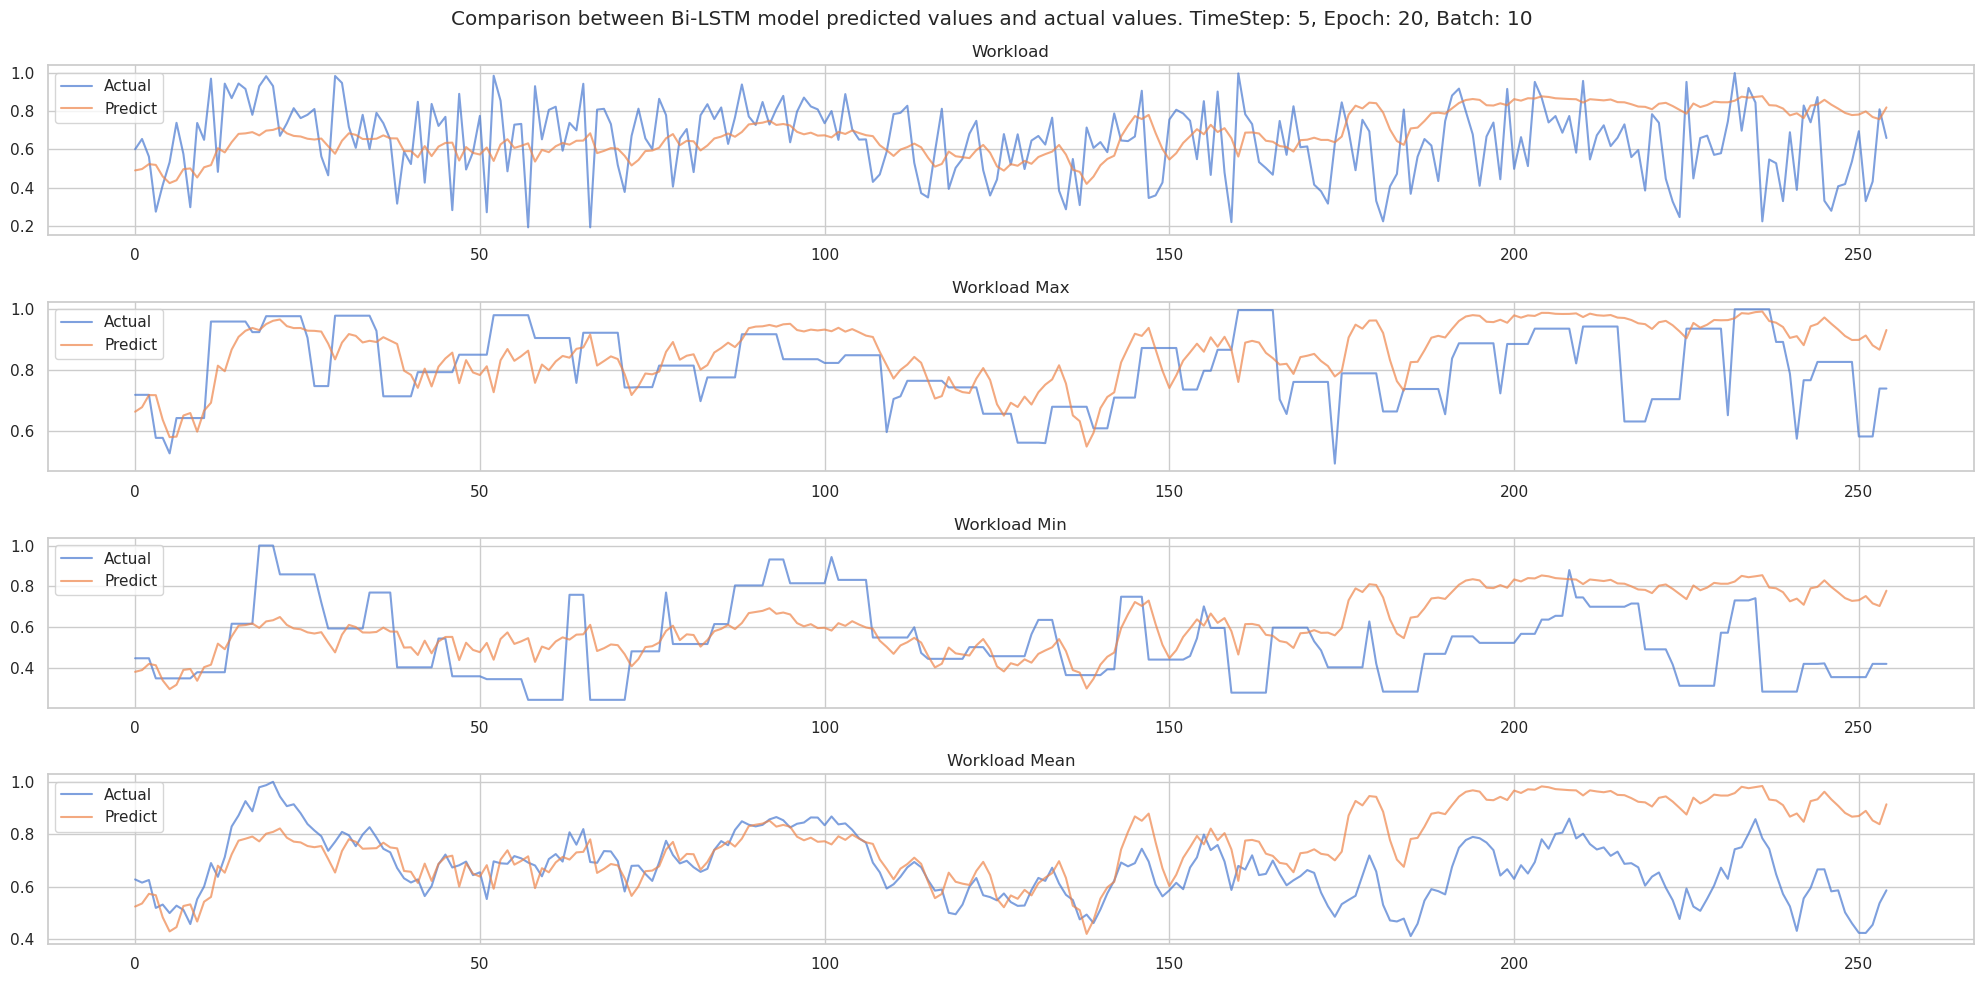

In [ ]:
bi_lstm_pred = predict(bi_lstm_model_trained, x_test, device)
y_pred = bi_lstm_pred

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 10))
axes = axes.flatten()


ax = axes[0]
ax.plot(y_test[:, 0], label='Actual', alpha=0.7)
ax.plot(y_pred[:, 0], label='Predict', alpha=0.7)
ax.set_title(f'Workload')
ax.legend()


ax = axes[1]
ax.plot(y_test[:, 1], label='Actual', alpha=0.7)
ax.plot(y_pred[:, 1], label='Predict', alpha=0.7)
ax.set_title(f'Workload Max')
ax.legend()

ax = axes[2]
ax.plot(y_test[:, 2], label='Actual', alpha=0.7)
ax.plot(y_pred[:, 2], label='Predict', alpha=0.7)
ax.set_title(f'Workload Min')
ax.legend()

ax = axes[3]
ax.plot(y_test[:, 3], label='Actual', alpha=0.7)
ax.plot(y_pred[:, 3], label='Predict', alpha=0.7)
ax.set_title(f'Workload Mean')
ax.legend()


fig.suptitle('Comparison between Bi-LSTM model predicted values and actual values. TimeStep: {timestep}, Epoch: {epoch}, Batch: {batch}'.format(
    timestep=TIME_STEP, epoch=epochs, batch=batch_size))
plt.tight_layout()
plt.show()


In [ ]:
attention_model = LSTM_fun_PyTorch_att(
    INPUT_DIM, TIME_STEP, output_dim).to(device)

# Reshape the data to match the expected input format of nn.Conv1d
attention_x_train = np.transpose(x_train, (0, 2, 1))
attention_x_val = np.transpose(x_val, (0, 2, 1))
attention_x_test = np.transpose(x_test, (0, 2, 1))

attention_model_trained = train_model(attention_x_train, y_train, attention_x_val, y_val, attention_model,
                                      epochs, batch_size, device)

/home/lwh/miniconda3/envs/service_workload/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/20, Loss: 0.052771
Validation Loss: 0.049870
Epoch 2/20, Loss: 0.039965
Validation Loss: 0.045063
Epoch 3/20, Loss: 0.039445
Validation Loss: 0.038181
Epoch 4/20, Loss: 0.035161
Validation Loss: 0.033538
Epoch 5/20, Loss: 0.032190
Validation Loss: 0.031594
Epoch 6/20, Loss: 0.028660
Validation Loss: 0.034096
Epoch 7/20, Loss: 0.025302
Validation Loss: 0.034523
Epoch 8/20, Loss: 0.021161
Validation Loss: 0.031804
Epoch 9/20, Loss: 0.018989
Validation Loss: 0.029978
Epoch 10/20, Loss: 0.016704
Validation Loss: 0.030517
Epoch 11/20, Loss: 0.014601
Validation Loss: 0.030000
Epoch 12/20, Loss: 0.013661
Validation Loss: 0.032979
Epoch 13/20, Loss: 0.014391
Validation Loss: 0.027757
Epoch 14/20, Loss: 0.012316
Validation Loss: 0.029585
Epoch 15/20, Loss: 0.011955
Validation Loss: 0.025557
Epoch 16/20, Loss: 0.011561
Validation Loss: 0.028679
Epoch 17/20, Loss: 0.011676
Validation Loss: 0.025082
Epoch 18/20, Loss: 0.011709
Validation Loss: 0.027391
Epoch 19/20, Loss: 0.010736
Validatio

In [ ]:
attention_pred, _, _ = predict(
    attention_model_trained, attention_x_test, device)

y_pred = attention_pred

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 10))
axes = axes.flatten()


ax = axes[0]
ax.plot(y_test[:, 0], label='Actual', alpha=0.7)
ax.plot(y_pred[:, 0], label='Predict', alpha=0.7)
ax.set_title(f'Workload')
ax.legend()


ax = axes[1]
ax.plot(y_test[:, 1], label='Actual', alpha=0.7)
ax.plot(y_pred[:, 1], label='Predict', alpha=0.7)
ax.set_title(f'Workload Max')
ax.legend()

ax = axes[2]
ax.plot(y_test[:, 2], label='Actual', alpha=0.7)
ax.plot(y_pred[:, 2], label='Predict', alpha=0.7)
ax.set_title(f'Workload Min')
ax.legend()

ax = axes[3]
ax.plot(y_test[:, 3], label='Actual', alpha=0.7)
ax.plot(y_pred[:, 3], label='Predict', alpha=0.7)
ax.set_title(f'Workload Mean')
ax.legend()


fig.suptitle('Comparison between Bi-LSTM-Attention model predicted values and actual values. TimeStep: {timestep}, Epoch: {epoch}, Batch: {batch}'.format(
    timestep=TIME_STEP, epoch=100, batch=batch_size))
plt.tight_layout()
plt.show()


AttributeError: 'tuple' object has no attribute 'eval'

In [ ]:
print(x_test.shape)

(3538, 5, 4)


In [ ]:
arima_pred = ARIMAModle.train(x_test[:, :, :1])


/home/lwh/miniconda3/envs/service_workload/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/lwh/miniconda3/envs/service_workload/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/lwh/miniconda3/envs/service_workload/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/lwh/miniconda3/envs/service_workload/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converg

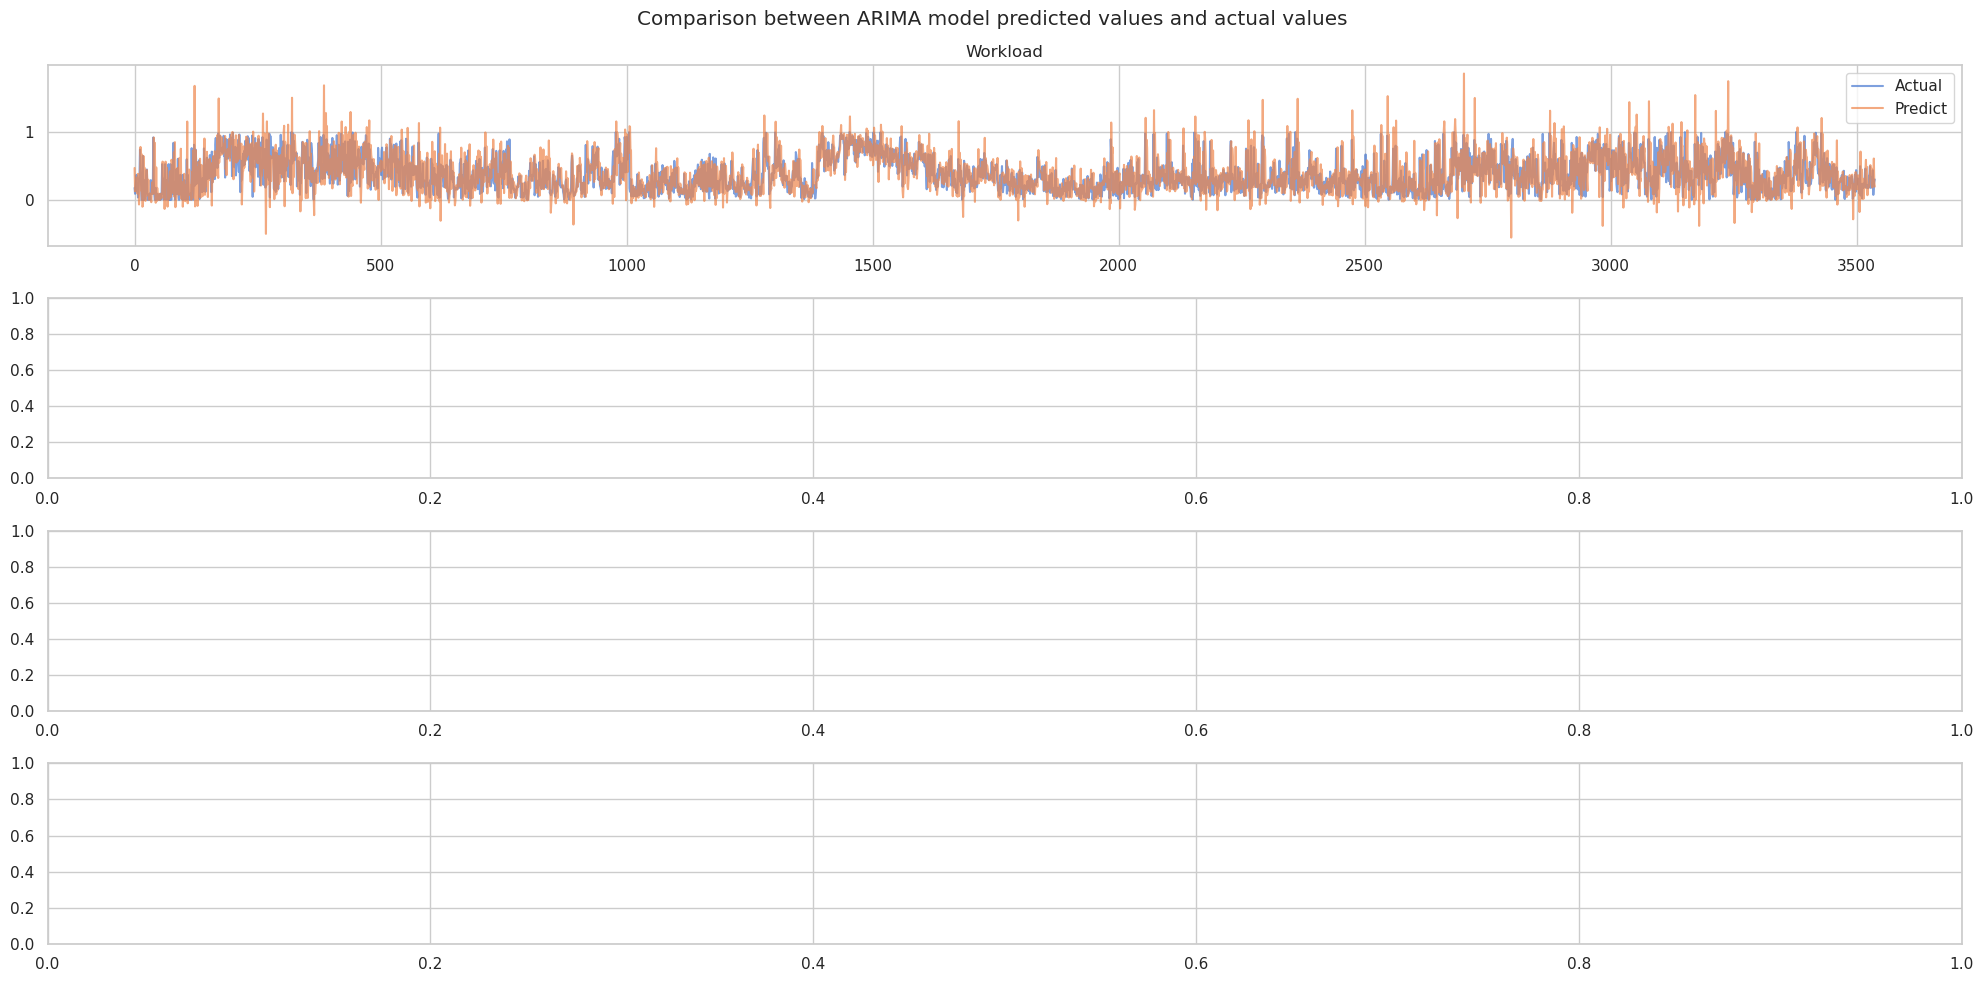

In [ ]:
y_pred = arima_pred

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 10))
axes = axes.flatten()


ax = axes[0]
ax.plot(y_test[:, :1], label='Actual', alpha=0.7)
ax.plot(y_pred, label='Predict', alpha=0.7)
ax.set_title(f'Workload')
ax.legend()


# ax = axes[1]
# ax.plot(y_test[:, 1], label='Actual', alpha=0.7)
# ax.plot(y_pred[:, 1], label='Predict', alpha=0.7)
# ax.set_title(f'Workload Max')
# ax.legend()

# ax = axes[2]
# ax.plot(y_test[:, 2], label='Actual', alpha=0.7)
# ax.plot(y_pred[:, 2], label='Predict', alpha=0.7)
# ax.set_title(f'Workload Min')
# ax.legend()

# ax = axes[3]
# ax.plot(y_test[:, 3], label='Actual', alpha=0.7)
# ax.plot(y_pred[:, 3], label='Predict', alpha=0.7)
# ax.set_title(f'Workload Mean')
# ax.legend()


fig.suptitle(
    'Comparison between ARIMA model predicted values and actual values')
plt.tight_layout()
plt.show()


In [ ]:
n_beats_model = NBeatsModel.model(input_dim=5,
                                  output_dim=1, hidden_size=hidden_size)
n_beats_model_trained = NBeatsModel.train_model(x_train[:, :, :1], y_train[:,  :1], x_val[:, :, :1], y_val[:,  :1], n_beats_model,
                                                70, batch_size, device)


| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=5, forecast_length=1, share_thetas=False) at @139794755332464
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=5, forecast_length=1, share_thetas=False) at @139794755332464
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=5, forecast_length=1, share_thetas=False) at @139794755332464
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=5, forecast_length=1, share_thetas=False) at @139794761491024
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=5, forecast_length=1, share_thetas=False) at @139794761491024
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=5, forecast_length=1, share_thetas=False) at @139794761491024
Epoch 1/70, Loss: 0.075995
Epoch 2/70, Loss: 0.043784
Epoch 3/70, Loss: 0.043409
Epoch 4/70, Loss: 0.041739
Epoch 5/70, Loss

AttributeError: 'Axes' object has no attribute 'flatten'

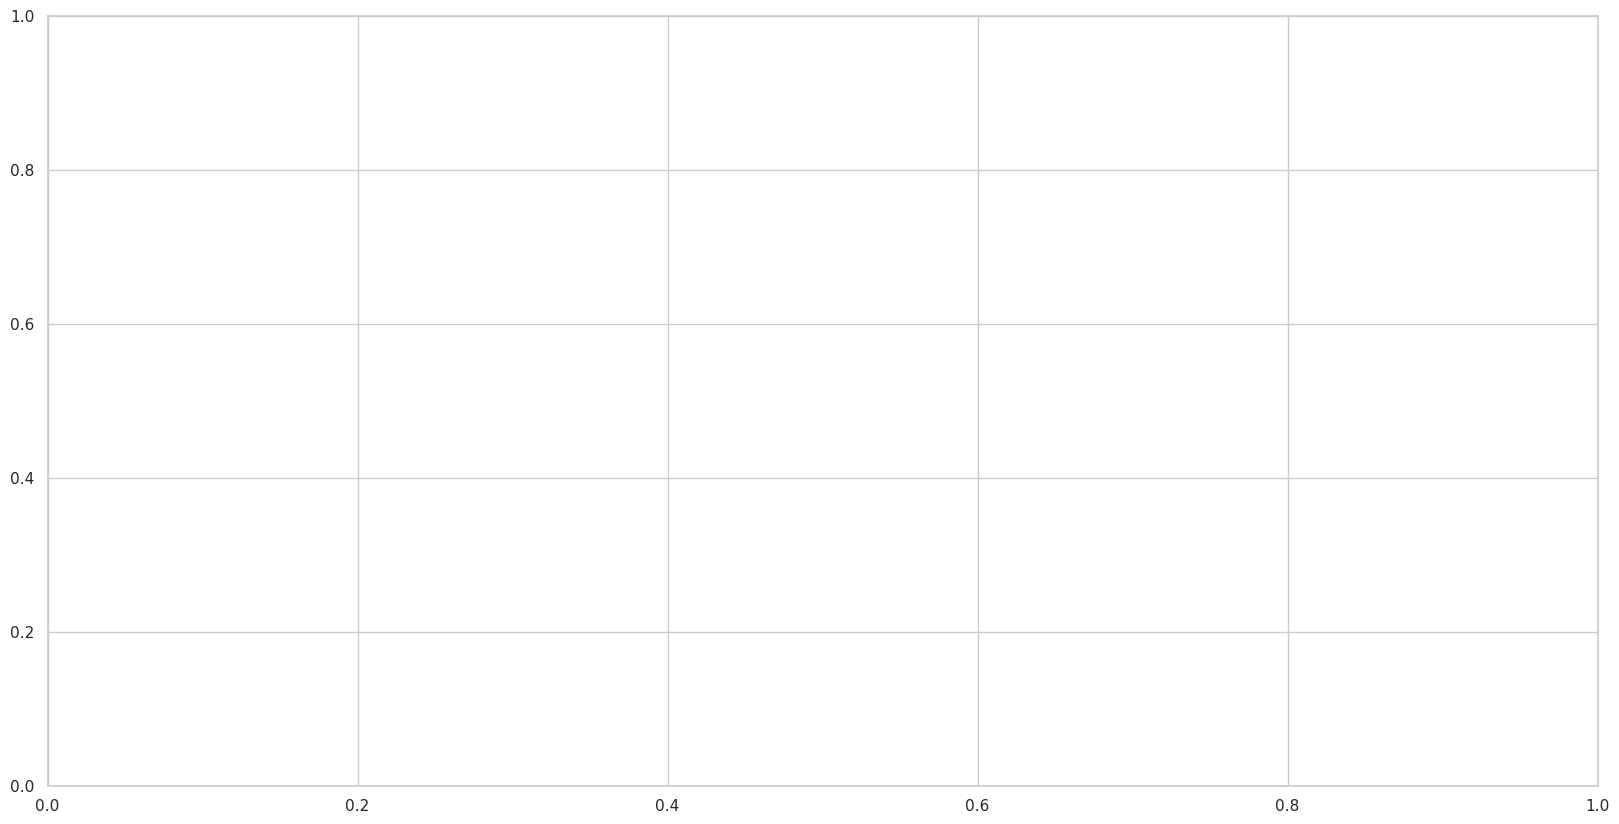

In [ ]:
n_beats_pred = NBeatsModel.predict(n_beats_model_trained, x_test[:,:,:1], device)

y_pred = n_beats_pred

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
axes = axes.flatten()


ax = axes[0]
ax.plot(y_test[:, :1], label='Actual', alpha=0.7)
ax.plot(y_pred[:, :1], label='Predict', alpha=0.7)
ax.set_title(f'Workload')
ax.legend()


# ax = axes[1]
# ax.plot(y_test[:, 1], label='Actual', alpha=0.7)
# ax.plot(y_pred[:, 1], label='Predict', alpha=0.7)
# ax.set_title(f'Workload Max')
# ax.legend()

# ax = axes[2]
# ax.plot(y_test[:, 2], label='Actual', alpha=0.7)
# ax.plot(y_pred[:, 2], label='Predict', alpha=0.7)
# ax.set_title(f'Workload Min')
# ax.legend()

# ax = axes[3]
# ax.plot(y_test[:, 3], label='Actual', alpha=0.7)
# ax.plot(y_pred[:, 3], label='Predict', alpha=0.7)
# ax.set_title(f'Workload Mean')
# ax.legend()


fig.suptitle('Comparison between N-Beats model predicted values and actual values. TimeStep: {timestep}, Epoch: {epoch}, Batch: {batch}'.format(
    timestep=TIME_STEP, epoch=70, batch=batch_size))
plt.tight_layout()
plt.show()


In [ ]:


y_test_tensor = torch.tensor(y_test[:, 0])
arima_pred_tensor = torch.tensor(arima_pred[:, 0])
n_breats_pred_tensor = torch.tensor(n_beats_pred[:, 0])
lstm_pred_tensor = torch.tensor(lstm_pred[:, 0])
bi_lstm_pred_tensor = torch.tensor(bi_lstm_pred[:, 0])
attention_pred_tensor = torch.tensor(attention_pred[:, 0])

# MSE
criterion = nn.MSELoss()

val_loss = criterion(arima_pred_tensor, y_test_tensor)
print("ARIMA MSE Validation Loss: {:.6f}".format(val_loss.item()))


val_loss = criterion(n_breats_pred_tensor, y_test_tensor)
print("N-Beats MSE Validation Loss: {:.6f}".format(val_loss.item()))


val_loss = criterion(lstm_pred_tensor, y_test_tensor)
print("LSTM MSE Validation Loss: {:.6f}".format(val_loss.item()))

val_loss = criterion(bi_lstm_pred_tensor, y_test_tensor)
print("BI-LSTM MSE Validation Loss: {:.6f}".format(val_loss.item()))

val_loss = criterion(attention_pred_tensor, y_test_tensor)
print("BI-LSTM-Attention MSE Validation Loss: {:.6f}".format(val_loss.item()))

print("--------------------------------------------------------------")

# MAE
criterion = nn.L1Loss()

val_loss = criterion(arima_pred_tensor, y_test_tensor)
print("ARIMA MAE Validation Loss: {:.6f}".format(val_loss.item()))

val_loss = criterion(n_breats_pred_tensor, y_test_tensor)
print("N-Beats MAE Validation Loss: {:.6f}".format(val_loss.item()))

val_loss = criterion(lstm_pred_tensor, y_test_tensor)
print("LSTM MAE Validation Loss: {:.6f}".format(val_loss.item()))

val_loss = criterion(bi_lstm_pred_tensor, y_test_tensor)
print("BI-LSTM MAE Validation Loss: {:.6f}".format(val_loss.item()))

val_loss = criterion(attention_pred_tensor, y_test_tensor)
print("BI-LSTM-Attention MAE Validation Loss: {:.6f}".format(val_loss.item()))

print("--------------------------------------------------------------")

# MAPE

pct_error = 100.0 * \
    torch.abs((arima_pred_tensor - y_test_tensor) /
              y_test_tensor)
isinf = torch.isinf(pct_error)
pct_error = torch.masked_select(pct_error, ~isinf)
print("ARIMA MAPE Validation Loss: {:.6f}".format(torch.mean(pct_error)))


pct_error = 100.0 * \
    torch.abs((n_breats_pred_tensor - y_test_tensor) /
              y_test_tensor)
isinf = torch.isinf(pct_error)
pct_error = torch.masked_select(pct_error, ~isinf)
print("N-Beats MAPE Validation Loss: {:.6f}".format(torch.mean(pct_error)))


pct_error = 100.0 * \
    torch.abs((lstm_pred_tensor - y_test_tensor) /
              y_test_tensor)
isinf = torch.isinf(pct_error)
pct_error = torch.masked_select(pct_error, ~isinf)
print("LSTM MAPE Validation Loss: {:.6f}".format(torch.mean(pct_error)))

pct_error = 100.0 * \
    torch.abs((bi_lstm_pred_tensor -
               y_test_tensor) / y_test_tensor)
isinf = torch.isinf(pct_error)
pct_error = torch.masked_select(pct_error, ~isinf)
print("BI-LSTM MAPE Validation Loss: {:.6f}".format(torch.mean(pct_error)))

pct_error = 100.0 * \
    torch.abs((attention_pred_tensor -
               y_test_tensor) / y_test_tensor)
isinf = torch.isinf(pct_error)
pct_error = torch.masked_select(pct_error, ~isinf)
print(
    "BI-LSTM-Attention MAPE Validation Loss: {:.6f}".format(torch.mean(pct_error)))


ARIMA MSE Validation Loss: 0.089349
N-Beats MSE Validation Loss: 0.039968
LSTM MSE Validation Loss: 0.053541
BI-LSTM MSE Validation Loss: 0.056452
BI-LSTM-Attention MSE Validation Loss: 0.039775
--------------------------------------------------------------
ARIMA MAE Validation Loss: 0.226288
N-Beats MAE Validation Loss: 0.155967
LSTM MAE Validation Loss: 0.177357
BI-LSTM MAE Validation Loss: 0.183297
BI-LSTM-Attention MAE Validation Loss: 0.157804
--------------------------------------------------------------
ARIMA MAPE Validation Loss: 186.020141
N-Beats MAPE Validation Loss: 232.086071
LSTM MAPE Validation Loss: 266.497511
BI-LSTM MAPE Validation Loss: 251.484726
BI-LSTM-Attention MAPE Validation Loss: 252.370895


In [ ]:
print(y_pred.shape)
print(y_val.shape)


(3538, 4)
(3537, 4)


array([ 0.20018977,  0.4165257 , -0.01709253,  0.21058731], dtype=float32)

In [ ]:
# fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 10))
# axes = axes.flatten()


# ax = axes[0]
# ax.plot(y_val[:, 0], label='Actual', alpha=0.7)
# ax.plot(y_pred[:, 0], label='Predict', alpha=0.7)
# ax.set_title(f'Workload')
# ax.legend()


# ax = axes[1]
# ax.plot(y_val[:, 1], label='Actual', alpha=0.7)
# ax.plot(y_pred[:, 1], label='Predict', alpha=0.7)
# ax.set_title(f'Workload Max')
# ax.legend()

# ax = axes[2]
# ax.plot(y_val[:, 2], label='Actual', alpha=0.7)
# ax.plot(y_pred[:, 2], label='Predict', alpha=0.7)
# ax.set_title(f'Workload Min')
# ax.legend()

# ax = axes[3]
# ax.plot(y_val[:, 3], label='Actual', alpha=0.7)
# ax.plot(y_pred[:, 3], label='Predict', alpha=0.7)
# ax.set_title(f'Workload Mean')
# ax.legend()



# fig.suptitle('Comparison of Columns in Two 2D Arrays')
# plt.tight_layout()
# plt.show()
